<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/QUANT017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 安装必要的依赖项
!pip install yfinance mplfinance  # 使用pip安装yfinance和mplfinance库

import sys  # 导入sys库，用于访问系统特定的参数和函数
import os   # 导入os库，用于与操作系统进行交互

import yfinance as yf  # 导入yfinance库，用于下载股票数据
import pandas as pd  # 导入pandas库，用于数据处理

def download_data(ticker, start_date, end_date):
    """
    下载股票数据并处理多重索引

    参数：
    ticker (str): 股票代码
    start_date (str): 开始日期
    end_date (str): 结束日期

    返回：
    pandas.DataFrame: 股票数据
    """
    df = yf.download(ticker, start=start_date, end=end_date)  # 使用yfinance下载股票数据
    df.columns = df.columns.droplevel(1)  # 删除第二级索引(ticker名称)
    return df  # 返回处理后的数据

# 设置参数
ticker = 'AAPL'  # 设置股票代码为AAPL（苹果公司）
start_date = '2020-01-01'  # 设置开始日期为2020年1月1日
end_date = '2023-10-26'  # 设置结束日期为2023年10月26日

# 下载数据
df = download_data(ticker, start_date, end_date)  # 调用函数下载股票数据
print(df.columns)  # 打印数据帧的列名
print(df.head(100))  # 打印数据帧的前100行
df.to_csv('stock_1d.csv')  # 将数据帧保存为名为'stock_1d.csv'的CSV文件

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Price           Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.716057  72.776583  71.466797  71.721004  135480400
2020-01-03  72.009125  72.771752  71.783969  71.941336  146322800
2020-01-06  72.582893  72.621631  70.876060  71.127851  118387200
2020-01-07  72.241539  72.849216  72.021223  72.592586  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200
...               ...        ...        ...        ...        ...
2020-05-19  76.198212  77.507353  76.166577  76.658113  101729600
2020-05-20  77.680145  77.750707  77.020699  77.059634  111504800
2020-05-21  77.100990  78.084070  76.862518  77.541428  102688800
2020-05-22  77.597389  77.680123  76.735978  76.838175   81803200
2020-05-26  77.071808  78.899256  77.015838  78.719190  125522000

[100 rows x 5 columns]


1. 完整覆盖了原代码中的所有特征：
* Alpha360的历史价格特征
* K线特征(KMID等9个)
* 价格和成交量特征
* 各类滚动窗口特征(超过30种)
2. 主要特征类别：
* 趋势类：MA, ROC, BETA等
* 波动类：STD, RESI等
* 位置类：RSV, RANK等
* 动量类：IMAX, IMIN等
* 相关性：CORR, CORD等
* 计数类：CNTP, CNTN等
* RSI类：SUMP, SUMN等
* 成交量类：VMA, VSTD等
3. 功能特点：
* 完全基于pandas实现
* 支持灵活的特征组合
* 支持自定义窗口大小
* 提供详细的特征计算说明
* 代码结构清晰，易于扩展
4. 使用方法灵活：
* 可以生成全部特征
* 可以选择特定类别的特征
* 可以自定义各类特征的参数

In [2]:
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Tuple
from scipy import stats

class AlphaFeatures:
    """
    股票技术指标特征工程类
    """
    def __init__(self, df: pd.DataFrame):
        """
        初始化

        参数:
        df: pd.DataFrame - 包含OHLCV数据的DataFrame
        """
        self.df = df.copy()
        # 确保列名标准化
        self.df.columns = [col.lower() for col in self.df.columns]
        # 添加vwap列
        self.df['vwap'] = (self.df['high'] + self.df['low'] + self.df['close']) / 3

    def get_alpha360_features(self, windows: int = 60) -> pd.DataFrame:
        """
        计算Alpha360特征
        """
        features = {}
        price_cols = ['close', 'open', 'high', 'low', 'vwap']

        for col in price_cols:
            # 当前值
            features[f'{col.upper()}0'] = self.df[col] / self.df['close']

            # 历史值
            for i in range(1, windows):
                features[f'{col.upper()}{i}'] = self.df[col].shift(i) / self.df['close']

        # 成交量特征
        features['VOLUME0'] = self.df['volume'] / (self.df['volume'] + 1e-12)
        for i in range(1, windows):
            features[f'VOLUME{i}'] = self.df['volume'].shift(i) / (self.df['volume'] + 1e-12)

        return pd.DataFrame(features, index=self.df.index)

    def get_kbar_features(self) -> pd.DataFrame:
        """
        计算K线特征
        """
        features = {}
        df = self.df

        # 基础K线特征
        features['KMID'] = (df['close'] - df['open']) / df['open']
        features['KLEN'] = (df['high'] - df['low']) / df['open']
        features['KMID2'] = (df['close'] - df['open']) / (df['high'] - df['low'] + 1e-12)

        # 上影线和下影线特征
        features['KUP'] = (df['high'] - df[['open', 'close']].max(axis=1)) / df['open']
        features['KUP2'] = (df['high'] - df[['open', 'close']].max(axis=1)) / (df['high'] - df['low'] + 1e-12)
        features['KLOW'] = (df[['open', 'close']].min(axis=1) - df['low']) / df['open']
        features['KLOW2'] = (df[['open', 'close']].min(axis=1) - df['low']) / (df['high'] - df['low'] + 1e-12)

        # 位移特征
        features['KSFT'] = (2 * df['close'] - df['high'] - df['low']) / df['open']
        features['KSFT2'] = (2 * df['close'] - df['high'] - df['low']) / (df['high'] - df['low'] + 1e-12)

        return pd.DataFrame(features, index=self.df.index)

    def get_price_volume_features(self, windows: List[int] = [0,1,2,3,4]) -> pd.DataFrame:
        """
        计算价格和成交量特征
        """
        features = {}
        fields = ['open', 'high', 'low', 'close', 'vwap']

        for field in fields:
            for d in windows:
                if d == 0:
                    features[f'{field.upper()}{d}'] = self.df[field] / self.df['close']
                else:
                    features[f'{field.upper()}{d}'] = self.df[field].shift(d) / self.df['close']

        for d in windows:
            if d == 0:
                features[f'VOLUME{d}'] = self.df['volume'] / (self.df['volume'] + 1e-12)
            else:
                features[f'VOLUME{d}'] = self.df['volume'].shift(d) / (self.df['volume'] + 1e-12)

        return pd.DataFrame(features, index=self.df.index)

    def get_rolling_features(self, windows: List[int] = [5, 10, 20, 30, 60]) -> pd.DataFrame:
        """
        计算滚动窗口特征
        """
        features = {}
        df = self.df

        for d in windows:
            # ROC - 价格变化率
            features[f'ROC{d}'] = df['close'].shift(d) / df['close']

            # MA - 移动平均
            features[f'MA{d}'] = df['close'].rolling(d).mean() / df['close']

            # STD - 标准差
            features[f'STD{d}'] = df['close'].rolling(d).std() / df['close']

            # BETA - 斜率
            features[f'BETA{d}'] = self._calculate_slope(df['close'], d) / df['close']

            # RSQR - R方值
            features[f'RSQR{d}'] = self._calculate_rsquare(df['close'], d)

            # RESI - 残差
            features[f'RESI{d}'] = self._calculate_residuals(df['close'], d) / df['close']

            # MAX/MIN/Quantile
            features[f'MAX{d}'] = df['high'].rolling(d).max() / df['close']
            features[f'MIN{d}'] = df['low'].rolling(d).min() / df['close']
            features[f'QTLU{d}'] = df['close'].rolling(d).quantile(0.8) / df['close']
            features[f'QTLD{d}'] = df['close'].rolling(d).quantile(0.2) / df['close']

            # RANK - 排名
            features[f'RANK{d}'] = df['close'].rolling(d).apply(
                lambda x: stats.percentileofscore(x.values, x.iloc[-1])
            ) / 100

            # RSV - 价格位置
            features[f'RSV{d}'] = (df['close'] - df['low'].rolling(d).min()) / \
                                (df['high'].rolling(d).max() - df['low'].rolling(d).min() + 1e-12)

            # IMAX/IMIN/IMXD - Aroon指标
            features[f'IMAX{d}'] = df['high'].rolling(d).apply(
                lambda x: len(x) - 1 - np.argmax(x.values)
            ) / d
            features[f'IMIN{d}'] = df['low'].rolling(d).apply(
                lambda x: len(x) - 1 - np.argmin(x.values)
            ) / d
            features[f'IMXD{d}'] = features[f'IMAX{d}'] - features[f'IMIN{d}']

            # 相关性特征
            features[f'CORR{d}'] = df['close'].rolling(d).corr(np.log(df['volume'] + 1))
            features[f'CORD{d}'] = (df['close'] / df['close'].shift(1)).rolling(d).corr(
                np.log(df['volume'] / df['volume'].shift(1) + 1)
            )

            # 计数特征
            price_up = (df['close'] > df['close'].shift(1)).astype(int)
            features[f'CNTP{d}'] = price_up.rolling(d).mean()
            features[f'CNTN{d}'] = (1 - price_up).rolling(d).mean()
            features[f'CNTD{d}'] = features[f'CNTP{d}'] - features[f'CNTN{d}']

            # RSI类特征
            price_diff = df['close'] - df['close'].shift(1)
            gain = np.where(price_diff > 0, price_diff, 0)
            loss = np.where(price_diff < 0, -price_diff, 0)
            abs_price_diff = abs(price_diff)

            features[f'SUMP{d}'] = pd.Series(gain).rolling(d).sum() / \
                                 (pd.Series(abs_price_diff).rolling(d).sum() + 1e-12)
            features[f'SUMN{d}'] = pd.Series(loss).rolling(d).sum() / \
                                 (pd.Series(abs_price_diff).rolling(d).sum() + 1e-12)
            features[f'SUMD{d}'] = features[f'SUMP{d}'] - features[f'SUMN{d}']

            # 成交量特征
            features[f'VMA{d}'] = df['volume'].rolling(d).mean() / (df['volume'] + 1e-12)
            features[f'VSTD{d}'] = df['volume'].rolling(d).std() / (df['volume'] + 1e-12)

            # 成交量加权波动率
            price_change = abs(df['close'] / df['close'].shift(1) - 1) * df['volume']
            features[f'WVMA{d}'] = price_change.rolling(d).std() / \
                                 (price_change.rolling(d).mean() + 1e-12)

            # 成交量RSI类特征
            volume_diff = df['volume'] - df['volume'].shift(1)
            volume_gain = np.where(volume_diff > 0, volume_diff, 0)
            volume_loss = np.where(volume_diff < 0, -volume_diff, 0)
            abs_volume_diff = abs(volume_diff)

            features[f'VSUMP{d}'] = pd.Series(volume_gain).rolling(d).sum() / \
                                  (pd.Series(abs_volume_diff).rolling(d).sum() + 1e-12)
            features[f'VSUMN{d}'] = pd.Series(volume_loss).rolling(d).sum() / \
                                  (pd.Series(abs_volume_diff).rolling(d).sum() + 1e-12)
            features[f'VSUMD{d}'] = features[f'VSUMP{d}'] - features[f'VSUMN{d}']

        return pd.DataFrame(features, index=self.df.index)

    def _calculate_slope(self, series: pd.Series, window: int) -> pd.Series:
        """计算滚动窗口的斜率"""
        def _slope(x):
            x = x.values  # 转换为numpy数组
            y = np.arange(len(x))
            A = np.vstack([y, np.ones(len(x))]).T
            return np.linalg.lstsq(A, x, rcond=None)[0][0]
        return series.rolling(window).apply(_slope)

    def _calculate_rsquare(self, series: pd.Series, window: int) -> pd.Series:
        """计算滚动窗口的R方值"""
        def _rsquare(x):
            x = x.values  # 转换为numpy数组
            y = np.arange(len(x))
            A = np.vstack([y, np.ones(len(x))]).T
            b = np.linalg.lstsq(A, x, rcond=None)[0]
            y_pred = A @ b
            ss_tot = np.sum((x - x.mean()) ** 2)
            ss_res = np.sum((x - y_pred) ** 2)
            return 1 - ss_res / ss_tot
        return series.rolling(window).apply(_rsquare)

    def _calculate_residuals(self, series: pd.Series, window: int) -> pd.Series:
        """计算滚动窗口的残差"""
        def _residuals(x):
            x = x.values  # 转换为numpy数组
            y = np.arange(len(x))
            A = np.vstack([y, np.ones(len(x))]).T
            b = np.linalg.lstsq(A, x, rcond=None)[0]
            y_pred = A @ b
            return x[-1] - y_pred[-1]
        return series.rolling(window).apply(_residuals)

    def generate_features(self,
                         alpha360: bool = True,
                         kbar: bool = True,
                         price_volume: bool = True,
                         rolling: bool = True,
                         alpha360_windows: int = 60,
                         price_volume_windows: List[int] = [0,1,2,3,4],
                         rolling_windows: List[int] = [5,10,20,30,60]) -> pd.DataFrame:
        """
        生成所有特征

        参数:
        alpha360: bool - 是否生成Alpha360特征
        kbar: bool - 是否生成K线特征
        price_volume: bool - 是否生成价格成交量特征
        rolling: bool - 是否生成滚动窗口特征
        alpha360_windows: int - Alpha360特征的窗口大小
        price_volume_windows: List[int] - 价格成交量特征的窗口大小列表
        rolling_windows: List[int] - 滚动窗口特征的窗口大小列表

        返回:
        pd.DataFrame - 特征数据
        """
        # 检查数据长度是否足够
        min_required_length = max([alpha360_windows] + rolling_windows) if rolling else alpha360_windows
        if len(self.df) < min_required_length:
            raise ValueError(f"Data length ({len(self.df)}) is less than minimum required length ({min_required_length})")

        feature_dfs = []

        if alpha360:
            feature_dfs.append(self.get_alpha360_features(alpha360_windows))
        if kbar:
            feature_dfs.append(self.get_kbar_features())
        if price_volume:
            feature_dfs.append(self.get_price_volume_features(price_volume_windows))
        if rolling:
            feature_dfs.append(self.get_rolling_features(rolling_windows))

        # 一次性合并所有特征
        if feature_dfs:
            result = pd.concat(feature_dfs, axis=1)
            # 删除全为NA的列
            result = result.dropna(axis=1, how='all')
            # 删除包含NA的行
            result = result.dropna(axis=0, how='any')
            return result

        return pd.DataFrame()

# 使用示例
if __name__ == "__main__":
    # 读取数据
    df = pd.read_csv('stock_1d.csv', index_col='Date', parse_dates=True)

    # 初始化特征工程类
    af = AlphaFeatures(df)

    # 生成所有特征
    features_df = af.generate_features()

    print("Feature shape:", features_df.shape)
    print("\nFeature columns:", features_df.columns.tolist())

Feature shape: (901, 514)

Feature columns: ['CLOSE0', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'CLOSE5', 'CLOSE6', 'CLOSE7', 'CLOSE8', 'CLOSE9', 'CLOSE10', 'CLOSE11', 'CLOSE12', 'CLOSE13', 'CLOSE14', 'CLOSE15', 'CLOSE16', 'CLOSE17', 'CLOSE18', 'CLOSE19', 'CLOSE20', 'CLOSE21', 'CLOSE22', 'CLOSE23', 'CLOSE24', 'CLOSE25', 'CLOSE26', 'CLOSE27', 'CLOSE28', 'CLOSE29', 'CLOSE30', 'CLOSE31', 'CLOSE32', 'CLOSE33', 'CLOSE34', 'CLOSE35', 'CLOSE36', 'CLOSE37', 'CLOSE38', 'CLOSE39', 'CLOSE40', 'CLOSE41', 'CLOSE42', 'CLOSE43', 'CLOSE44', 'CLOSE45', 'CLOSE46', 'CLOSE47', 'CLOSE48', 'CLOSE49', 'CLOSE50', 'CLOSE51', 'CLOSE52', 'CLOSE53', 'CLOSE54', 'CLOSE55', 'CLOSE56', 'CLOSE57', 'CLOSE58', 'CLOSE59', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'OPEN5', 'OPEN6', 'OPEN7', 'OPEN8', 'OPEN9', 'OPEN10', 'OPEN11', 'OPEN12', 'OPEN13', 'OPEN14', 'OPEN15', 'OPEN16', 'OPEN17', 'OPEN18', 'OPEN19', 'OPEN20', 'OPEN21', 'OPEN22', 'OPEN23', 'OPEN24', 'OPEN25', 'OPEN26', 'OPEN27', 'OPEN28', 'OPEN29', 'OPEN30', 'OPEN

In [3]:
features_df.head(10)

,CLOSE0,CLOSE1,CLOSE2,CLOSE3,CLOSE4,CLOSE5,CLOSE6,CLOSE7,CLOSE8,CLOSE9,...,IMIN60,IMXD60,CORR60,CORD60,CNTP60,CNTN60,CNTD60,VMA60,VSTD60,WVMA60
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,1.0,0.972254,1.014246,0.963542,0.968879,0.880539,0.899651,0.960638,0.968055,0.992347,...,0.083333,0.45,-0.805677,-0.391013,0.450000,0.550000,-0.100000,1.180844,0.560479,1.428130
2020-03-31,1.0,1.002045,0.974242,1.016320,0.965512,0.970860,0.882339,0.901490,0.962602,0.970034,...,0.100000,0.45,-0.798328,-0.389614,0.450000,0.550000,-0.100000,1.011150,0.476642,1.432697
2020-04-01,1.0,1.055540,1.057698,1.028351,1.072766,1.019136,1.024781,0.931344,0.951559,1.016064,...,0.116667,0.45,-0.779260,-0.373406,0.433333,0.566667,-0.133333,1.135877,0.529747,1.402840
2020-04-02,1.0,0.983587,1.038215,1.040338,1.011473,1.055158,1.002409,1.007961,0.916057,0.935941,...,0.133333,0.45,-0.763308,-0.375695,0.450000,0.550000,-0.100000,1.212009,0.558618,1.393338
2020-04-03,1.0,1.014581,0.997929,1.053353,1.055507,1.026221,1.070544,1.017025,1.022658,0.929415,...,0.150000,0.45,-0.723165,-0.375499,0.433333,0.566667,-0.133333,1.548174,0.713904,1.394403
2020-04-06,1.0,0.919763,0.933174,0.917857,0.968835,0.970816,0.943880,0.984646,0.935421,0.940603,...,0.166667,0.45,-0.722208,-0.304125,0.433333,0.566667,-0.133333,0.998935,0.458986,1.361223
2020-04-07,1.0,1.011718,0.930540,0.944108,0.928613,0.980187,0.982192,0.954940,0.996184,0.946382,...,0.183333,0.45,-0.718343,-0.304089,0.416667,0.583333,-0.166667,0.998795,0.454865,1.352907
2020-04-08,1.0,0.975044,0.986469,0.907318,0.920547,0.905438,0.955726,0.957680,0.931108,0.971323,...,0.200000,0.45,-0.708882,-0.305703,0.416667,0.583333,-0.166667,1.204488,0.543426,1.346582
2020-04-09,1.0,0.992836,0.968059,0.979402,0.900818,0.913952,0.898952,0.948879,0.950819,0.924438,...,0.216667,0.45,-0.703057,-0.304604,0.433333,0.566667,-0.133333,1.257024,0.567139,1.350659


In [4]:
features_df.to_csv('stock_1d_features.csv')

In [5]:
class FeatureTransformer:
    """特征转换类，用于处理时间序列特征的滞后和滚动计算"""

    def __init__(self, df: pd.DataFrame):
        """
        初始化

        参数:
        df: pd.DataFrame - 输入数据框
        """
        self.df = df.copy()
        # 确保索引是时间类型
        if not isinstance(self.df.index, pd.DatetimeIndex):
            try:
                self.df.index = pd.to_datetime(self.df.index)
            except Exception as e:
                raise ValueError(f"无法将索引转换为日期类型: {str(e)}")

    def add_lag_feature(self,
                       column: str,
                       lag_periods: List[int],
                       prefix: str = None) -> pd.DataFrame:
        """
        为指定列添加滞后特征

        参数:
        column: str - 要处理的列名
        lag_periods: List[int] - 滞后期数列表
        prefix: str - 新特征的前缀，默认使用原列名

        返回:
        pd.DataFrame - 包含新增特征的数据框
        """
        if prefix is None:
            prefix = column

        for lag in lag_periods:
            self.df[f'{prefix}_lag_{lag}'] = self.df[column].shift(lag)

        return self.df

    def add_rolling_feature(self,
                          column: str,
                          windows: List[int],
                          functions: List[str],
                          min_periods: int = None,
                          prefix: str = None) -> pd.DataFrame:
        """
        为指定列添加滚动窗口特征

        参数:
        column: str - 要处理的列名
        windows: List[int] - 窗口大小列表
        functions: List[str] - 要应用的函数列表，支持 ['mean', 'std', 'min', 'max', 'quantile']
        min_periods: int - 最小所需观察值数量，默认为窗口大小
        prefix: str - 新特征的前缀，默认使用原列名

        返回:
        pd.DataFrame - 包含新增特征的数据框
        """
        if prefix is None:
            prefix = column

        valid_functions = {
            'mean': lambda x: x.mean(),
            'std': lambda x: x.std(),
            'min': lambda x: x.min(),
            'max': lambda x: x.max(),
            'quantile': lambda x: x.quantile(0.5)  # 默认使用中位数
        }

        for window in windows:
            if min_periods is None:
                min_periods = window

            rolling = self.df[column].rolling(window=window, min_periods=min_periods)

            for func in functions:
                if func.lower() not in valid_functions:
                    raise ValueError(f"不支持的函数: {func}. 支持的函数: {list(valid_functions.keys())}")

                feature_name = f'{prefix}_rolling_{window}_{func.lower()}'
                self.df[feature_name] = rolling.apply(valid_functions[func.lower()])

        return self.df

    def add_rolling_quantile_feature(self,
                                   column: str,
                                   windows: List[int],
                                   quantiles: List[float],
                                   min_periods: int = None,
                                   prefix: str = None) -> pd.DataFrame:
        """
        为指定列添加滚动分位数特征

        参数:
        column: str - 要处理的列名
        windows: List[int] - 窗口大小列表
        quantiles: List[float] - 分位数列表 (0-1之间)
        min_periods: int - 最小所需观察值数量，默认为窗口大小
        prefix: str - 新特征的前缀，默认使用原列名

        返回:
        pd.DataFrame - 包含新增特征的数据框
        """
        if prefix is None:
            prefix = column

        for window in windows:
            if min_periods is None:
                min_periods = window

            rolling = self.df[column].rolling(window=window, min_periods=min_periods)

            for q in quantiles:
                if not 0 <= q <= 1:
                    raise ValueError(f"分位数必须在0和1之间: {q}")

                feature_name = f'{prefix}_rolling_{window}_quantile_{int(q*100)}'
                self.df[feature_name] = rolling.quantile(q)

        return self.df

    def add_all_features(self,
                        column: str,
                        lag_periods: List[int] = None,
                        windows: List[int] = None,
                        functions: List[str] = None,
                        quantiles: List[float] = None,
                        prefix: str = None) -> pd.DataFrame:
        """
        为指定列添加所有类型的特征

        参数:
        column: str - 要处理的列名
        lag_periods: List[int] - 滞后期数列表
        windows: List[int] - 窗口大小列表
        functions: List[str] - 要应用的函数列表
        quantiles: List[float] - 分位数列表
        prefix: str - 新特征的前缀

        返回:
        pd.DataFrame - 包含所有新增特征的数据框
        """
        if lag_periods:
            self.add_lag_feature(column, lag_periods, prefix)

        if windows and functions:
            self.add_rolling_feature(column, windows, functions, prefix=prefix)

        if windows and quantiles:
            self.add_rolling_quantile_feature(column, windows, quantiles, prefix=prefix)

        return self.df

    def get_feature_names(self) -> List[str]:
        """
        获取所有特征名称

        返回:
        List[str] - 特征名称列表
        """
        return list(self.df.columns)

# 连接数据
def merge_features(df: pd.DataFrame, features_df: pd.DataFrame) -> pd.DataFrame:
    """
    将原始数据框与特征数据框按日期连接

    参数:
    df: pd.DataFrame - 原始数据框
    features_df: pd.DataFrame - 特征数据框

    返回:
    pd.DataFrame - 连接后的数据框
    """
    # 确保两个数据框都有日期索引
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    if not isinstance(features_df.index, pd.DatetimeIndex):
        features_df.index = pd.to_datetime(features_df.index)

    # 合并数据
    merged_df = pd.merge(df,
                        features_df,
                        left_index=True,
                        right_index=True,
                        how='left')

    return merged_df

# 使用示例
if __name__ == "__main__":
    # 假设我们有原始数据和特征数据
    df = pd.read_csv('stock_1d.csv', index_col='Date', parse_dates=True)
    features_df = pd.read_csv('stock_1d_features.csv', index_col='Date', parse_dates=True)

    # 合并数据
    merged_df = merge_features(df, features_df)
    print("合并后的数据形状:", merged_df.shape)

    # 创建特征转换器
    transformer = FeatureTransformer(merged_df)

    # 添加滞后特征
    lag_periods = [1, 2, 3, 5, 10]
    transformer.add_lag_feature('Close', lag_periods)

    # 添加滚动特征
    windows = [5, 10, 20, 60]
    functions = ['mean', 'std', 'min', 'max']
    transformer.add_rolling_feature('Close', windows, functions)

    # 添加滚动分位数特征
    quantiles = [0.25, 0.5, 0.75]
    transformer.add_rolling_quantile_feature('Close', windows, quantiles)

    # 获取所有特征名称
    feature_names = transformer.get_feature_names()
    print("\n生成的特征:")
    for name in feature_names:
        print(name)

    # 获取最终的特征数据框
    final_df = transformer.df
    print("\n最终数据形状:", final_df.shape)

合并后的数据形状: (961, 519)

生成的特征:
Close
High
Low
Open
Volume
CLOSE0
CLOSE1
CLOSE2
CLOSE3
CLOSE4
CLOSE5
CLOSE6
CLOSE7
CLOSE8
CLOSE9
CLOSE10
CLOSE11
CLOSE12
CLOSE13
CLOSE14
CLOSE15
CLOSE16
CLOSE17
CLOSE18
CLOSE19
CLOSE20
CLOSE21
CLOSE22
CLOSE23
CLOSE24
CLOSE25
CLOSE26
CLOSE27
CLOSE28
CLOSE29
CLOSE30
CLOSE31
CLOSE32
CLOSE33
CLOSE34
CLOSE35
CLOSE36
CLOSE37
CLOSE38
CLOSE39
CLOSE40
CLOSE41
CLOSE42
CLOSE43
CLOSE44
CLOSE45
CLOSE46
CLOSE47
CLOSE48
CLOSE49
CLOSE50
CLOSE51
CLOSE52
CLOSE53
CLOSE54
CLOSE55
CLOSE56
CLOSE57
CLOSE58
CLOSE59
OPEN0
OPEN1
OPEN2
OPEN3
OPEN4
OPEN5
OPEN6
OPEN7
OPEN8
OPEN9
OPEN10
OPEN11
OPEN12
OPEN13
OPEN14
OPEN15
OPEN16
OPEN17
OPEN18
OPEN19
OPEN20
OPEN21
OPEN22
OPEN23
OPEN24
OPEN25
OPEN26
OPEN27
OPEN28
OPEN29
OPEN30
OPEN31
OPEN32
OPEN33
OPEN34
OPEN35
OPEN36
OPEN37
OPEN38
OPEN39
OPEN40
OPEN41
OPEN42
OPEN43
OPEN44
OPEN45
OPEN46
OPEN47
OPEN48
OPEN49
OPEN50
OPEN51
OPEN52
OPEN53
OPEN54
OPEN55
OPEN56
OPEN57
OPEN58
OPEN59
HIGH0
HIGH1
HIGH2
HIGH3
HIGH4
HIGH5
HIGH6
HIGH7
HIGH8
HIGH9
HIGH

In [6]:
from typing import Dict, List, Union, Callable, Optional, Tuple
from dataclasses import dataclass
from enum import Enum
import yaml
import json

class FeatureType(Enum):
    """特征类型枚举"""
    LAG = "lag"
    ROLLING = "rolling"
    ROLLING_QUANTILE = "rolling_quantile"

@dataclass
class FeatureConfig:
    """特征配置数据类"""
    feature_type: FeatureType
    column: str
    windows: Optional[List[int]] = None  # 用于rolling和rolling_quantile
    lag_periods: Optional[List[int]] = None  # 用于lag
    functions: Optional[List[str]] = None  # 用于rolling
    quantiles: Optional[List[float]] = None  # 用于rolling_quantile
    prefix: Optional[str] = None

class FeatureConfigManager:
    """特征配置管理类"""

    def __init__(self):
        self.configs: List[FeatureConfig] = []

    def add_lag_config(self,
                      column: str,
                      lag_periods: List[int],
                      prefix: str = None) -> None:
        """添加滞后特征配置"""
        config = FeatureConfig(
            feature_type=FeatureType.LAG,
            column=column,
            lag_periods=lag_periods,
            prefix=prefix
        )
        self.configs.append(config)

    def add_rolling_config(self,
                          column: str,
                          windows: List[int],
                          functions: List[str],
                          prefix: str = None) -> None:
        """添加滚动特征配置"""
        config = FeatureConfig(
            feature_type=FeatureType.ROLLING,
            column=column,
            windows=windows,
            functions=functions,
            prefix=prefix
        )
        self.configs.append(config)

    def add_rolling_quantile_config(self,
                                  column: str,
                                  windows: List[int],
                                  quantiles: List[float],
                                  prefix: str = None) -> None:
        """添加滚动分位数特征配置"""
        config = FeatureConfig(
            feature_type=FeatureType.ROLLING_QUANTILE,
            column=column,
            windows=windows,
            quantiles=quantiles,
            prefix=prefix
        )
        self.configs.append(config)

    def load_from_dict(self, config_dict: Dict) -> None:
        """从字典加载配置"""
        self.configs = []
        for feature_config in config_dict.get('features', []):
            feature_type = FeatureType(feature_config['type'])

            if feature_type == FeatureType.LAG:
                self.add_lag_config(
                    column=feature_config['column'],
                    lag_periods=feature_config['lag_periods'],
                    prefix=feature_config.get('prefix')
                )
            elif feature_type == FeatureType.ROLLING:
                self.add_rolling_config(
                    column=feature_config['column'],
                    windows=feature_config['windows'],
                    functions=feature_config['functions'],
                    prefix=feature_config.get('prefix')
                )
            elif feature_type == FeatureType.ROLLING_QUANTILE:
                self.add_rolling_quantile_config(
                    column=feature_config['column'],
                    windows=feature_config['windows'],
                    quantiles=feature_config['quantiles'],
                    prefix=feature_config.get('prefix')
                )

    def load_from_yaml(self, yaml_path: str) -> None:
        """从YAML文件加载配置"""
        with open(yaml_path, 'r') as f:
            config_dict = yaml.safe_load(f)
        self.load_from_dict(config_dict)

    def load_from_json(self, json_path: str) -> None:
        """从JSON文件加载配置"""
        with open(json_path, 'r') as f:
            config_dict = json.load(f)
        self.load_from_dict(config_dict)

    def save_to_yaml(self, yaml_path: str) -> None:
        """保存配置到YAML文件"""
        config_dict = {'features': []}
        for config in self.configs:
            feature_dict = {
                'type': config.feature_type.value,
                'column': config.column
            }
            if config.prefix:
                feature_dict['prefix'] = config.prefix

            if config.windows:
                feature_dict['windows'] = config.windows
            if config.lag_periods:
                feature_dict['lag_periods'] = config.lag_periods
            if config.functions:
                feature_dict['functions'] = config.functions
            if config.quantiles:
                feature_dict['quantiles'] = config.quantiles

            config_dict['features'].append(feature_dict)

        with open(yaml_path, 'w') as f:
            yaml.dump(config_dict, f)

    def save_to_json(self, json_path: str) -> None:
        """保存配置到JSON文件"""
        config_dict = {'features': []}
        for config in self.configs:
            feature_dict = {
                'type': config.feature_type.value,
                'column': config.column
            }
            if config.prefix:
                feature_dict['prefix'] = config.prefix

            if config.windows:
                feature_dict['windows'] = config.windows
            if config.lag_periods:
                feature_dict['lag_periods'] = config.lag_periods
            if config.functions:
                feature_dict['functions'] = config.functions
            if config.quantiles:
                feature_dict['quantiles'] = config.quantiles

            config_dict['features'].append(feature_dict)

        with open(json_path, 'w') as f:
            json.dump(config_dict, f, indent=4)

class EnhancedFeatureTransformer(FeatureTransformer):
    """增强版特征转换器，支持配置管理"""

    def __init__(self, df: pd.DataFrame, config_manager: Optional[FeatureConfigManager] = None):
        """
        初始化

        参数:
        df: pd.DataFrame - 输入数据框
        config_manager: FeatureConfigManager - 特征配置管理器
        """
        super().__init__(df)
        self.config_manager = config_manager or FeatureConfigManager()

    def apply_configs(self) -> pd.DataFrame:
        """应用所有配置生成特征"""
        for config in self.config_manager.configs:
            if config.feature_type == FeatureType.LAG:
                self.add_lag_feature(
                    column=config.column,
                    lag_periods=config.lag_periods,
                    prefix=config.prefix
                )
            elif config.feature_type == FeatureType.ROLLING:
                self.add_rolling_feature(
                    column=config.column,
                    windows=config.windows,
                    functions=config.functions,
                    prefix=config.prefix
                )
            elif config.feature_type == FeatureType.ROLLING_QUANTILE:
                self.add_rolling_quantile_feature(
                    column=config.column,
                    windows=config.windows,
                    quantiles=config.quantiles,
                    prefix=config.prefix
                )
        return self.df

# 使用示例
if __name__ == "__main__":
    # 创建配置
    config_manager = FeatureConfigManager()

    # 添加滞后特征配置
    config_manager.add_lag_config(
        column='Close',
        lag_periods=[1, 2, 3, 5, 10]
    )

    # 添加滚动特征配置
    config_manager.add_rolling_config(
        column='Close',
        windows=[5, 10, 20, 60],
        functions=['mean', 'std', 'min', 'max']
    )

    # 添加滚动分位数特征配置
    config_manager.add_rolling_quantile_config(
        column='Close',
        windows=[10, 20, 60],
        quantiles=[0.25, 0.5, 0.75]
    )

    # 保存配置到文件
    config_manager.save_to_yaml('feature_config.yaml')
    config_manager.save_to_json('feature_config.json')

    # 读取数据
    df = pd.read_csv('stock_1d.csv', index_col='Date', parse_dates=True)
    features_df = pd.read_csv('stock_1d_features.csv', index_col='Date', parse_dates=True)

    # 合并数据
    merged_df = merge_features(df, features_df)
    print("合并后的数据形状:", merged_df.shape)

    # 创建特征转换器并应用配置
    transformer = EnhancedFeatureTransformer(merged_df, config_manager)
    final_df = transformer.apply_configs()

    print("\n生成的特征:")
    for col in final_df.columns:
        if '_lag_' in col or '_rolling_' in col:
            print(f"- {col}")

    print("\n最终数据形状:", final_df.shape)

合并后的数据形状: (961, 519)

生成的特征:
- Close_lag_1
- Close_lag_2
- Close_lag_3
- Close_lag_5
- Close_lag_10
- Close_rolling_5_mean
- Close_rolling_5_std
- Close_rolling_5_min
- Close_rolling_5_max
- Close_rolling_10_mean
- Close_rolling_10_std
- Close_rolling_10_min
- Close_rolling_10_max
- Close_rolling_20_mean
- Close_rolling_20_std
- Close_rolling_20_min
- Close_rolling_20_max
- Close_rolling_60_mean
- Close_rolling_60_std
- Close_rolling_60_min
- Close_rolling_60_max
- Close_rolling_10_quantile_25
- Close_rolling_10_quantile_50
- Close_rolling_10_quantile_75
- Close_rolling_20_quantile_25
- Close_rolling_20_quantile_50
- Close_rolling_20_quantile_75
- Close_rolling_60_quantile_25
- Close_rolling_60_quantile_50
- Close_rolling_60_quantile_75

最终数据形状: (961, 549)


In [7]:
@dataclass
class FeatureConfig:
    """特征配置数据类"""
    feature_type: FeatureType
    columns: Union[str, List[str]]  # 支持单个列名或列名列表
    windows: Optional[List[int]] = None  # 用于rolling和rolling_quantile
    lag_periods: Optional[List[int]] = None  # 用于lag
    functions: Optional[List[str]] = None  # 用于rolling
    quantiles: Optional[List[float]] = None  # 用于rolling_quantile
    prefix: Optional[Union[str, Dict[str, str]]] = None  # 支持每列单独设置前缀

class FeatureConfigManager:
    """特征配置管理类"""

    def __init__(self):
        self.configs: List[FeatureConfig] = []

    def _config_to_dict(self, config: FeatureConfig) -> Dict:
        """将FeatureConfig对象转换为字典"""
        config_dict = {
            'type': config.feature_type.value,
            'columns': config.columns
        }

        # 添加非None的可选参数
        if config.windows is not None:
            config_dict['windows'] = config.windows
        if config.lag_periods is not None:
            config_dict['lag_periods'] = config.lag_periods
        if config.functions is not None:
            config_dict['functions'] = config.functions
        if config.quantiles is not None:
            config_dict['quantiles'] = config.quantiles
        if config.prefix is not None:
            config_dict['prefix'] = config.prefix

        return config_dict

    def _dict_to_config(self, config_dict: Dict) -> FeatureConfig:
        """将字典转换为FeatureConfig对象"""
        feature_type = FeatureType(config_dict['type'])

        # 创建基础配置
        config = FeatureConfig(
            feature_type=feature_type,
            columns=config_dict['columns']
        )

        # 设置可选参数
        if 'windows' in config_dict:
            config.windows = config_dict['windows']
        if 'lag_periods' in config_dict:
            config.lag_periods = config_dict['lag_periods']
        if 'functions' in config_dict:
            config.functions = config_dict['functions']
        if 'quantiles' in config_dict:
            config.quantiles = config_dict['quantiles']
        if 'prefix' in config_dict:
            config.prefix = config_dict['prefix']

        return config

    def save_to_yaml(self, yaml_path: str) -> None:
        """
        保存配置到YAML文件

        参数:
        yaml_path: str - YAML文件路径
        """
        try:
            # 将所有配置转换为字典列表
            config_dicts = [self._config_to_dict(config) for config in self.configs]

            # 创建完整的配置字典
            full_config = {
                'version': '1.0',  # 添加版本信息便于后续扩展
                'features': config_dicts
            }

            # 保存到YAML文件
            with open(yaml_path, 'w', encoding='utf-8') as f:
                yaml.dump(full_config, f, default_flow_style=False, sort_keys=False)

            print(f"配置已保存到: {yaml_path}")

        except Exception as e:
            print(f"保存YAML配置时出错: {str(e)}")
            raise

    def save_to_json(self, json_path: str) -> None:
        """
        保存配置到JSON文件

        参数:
        json_path: str - JSON文件路径
        """
        try:
            # 将所有配置转换为字典列表
            config_dicts = [self._config_to_dict(config) for config in self.configs]

            # 创建完整的配置字典
            full_config = {
                'version': '1.0',  # 添加版本信息便于后续扩展
                'features': config_dicts
            }

            # 保存到JSON文件
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(full_config, f, indent=4, ensure_ascii=False)

            print(f"配置已保存到: {json_path}")

        except Exception as e:
            print(f"保存JSON配置时出错: {str(e)}")
            raise

    def load_from_yaml(self, yaml_path: str) -> None:
        """
        从YAML文件加载配置

        参数:
        yaml_path: str - YAML文件路径
        """
        try:
            # 读取YAML文件
            with open(yaml_path, 'r', encoding='utf-8') as f:
                config_data = yaml.safe_load(f)

            # 检查版本兼容性
            version = config_data.get('version', '1.0')
            if version != '1.0':
                print(f"警告: 配置文件版本 ({version}) 可能与当前版本不兼容")

            # 清空现有配置
            self.configs = []

            # 转换并添加配置
            for config_dict in config_data.get('features', []):
                config = self._dict_to_config(config_dict)
                self.configs.append(config)

            print(f"已从 {yaml_path} 加载 {len(self.configs)} 个配置")

        except Exception as e:
            print(f"加载YAML配置时出错: {str(e)}")
            raise

    def load_from_json(self, json_path: str) -> None:
        """
        从JSON文件加载配置

        参数:
        json_path: str - JSON文件路径
        """
        try:
            # 读取JSON文件
            with open(json_path, 'r', encoding='utf-8') as f:
                config_data = json.load(f)

            # 检查版本兼容性
            version = config_data.get('version', '1.0')
            if version != '1.0':
                print(f"警告: 配置文件版本 ({version}) 可能与当前版本不兼容")

            # 清空现有配置
            self.configs = []

            # 转换并添加配置
            for config_dict in config_data.get('features', []):
                config = self._dict_to_config(config_dict)
                self.configs.append(config)

            print(f"已从 {json_path} 加载 {len(self.configs)} 个配置")

        except Exception as e:
            print(f"加载JSON配置时出错: {str(e)}")
            raise


    def _ensure_list(self, value: Union[str, List[str]]) -> List[str]:
        """确保输入为列表形式"""
        if isinstance(value, str):
            return [value]
        return value

    def _process_prefix(self,
                       columns: Union[str, List[str]],
                       prefix: Optional[Union[str, Dict[str, str], List[str]]] = None
                       ) -> Optional[Union[str, Dict[str, str]]]:
        """处理前缀设置"""
        columns = self._ensure_list(columns)

        if prefix is None:
            return None

        if isinstance(prefix, str):
            if len(columns) == 1:
                return prefix
            return {col: f"{prefix}_{col.lower()}" for col in columns}

        if isinstance(prefix, list):
            if len(prefix) != len(columns):
                raise ValueError("前缀列表长度必须与列数相同")
            return dict(zip(columns, prefix))

        if isinstance(prefix, dict):
            # 确保所有列都有对应的前缀
            missing_cols = set(columns) - set(prefix.keys())
            if missing_cols:
                # 对缺失前缀的列使用列名作为前缀
                for col in missing_cols:
                    prefix[col] = col.lower()
            return prefix

        raise ValueError("不支持的前缀格式")

    def add_lag_config(self,
                      columns: Union[str, List[str]],
                      lag_periods: List[int],
                      prefix: Optional[Union[str, Dict[str, str], List[str]]] = None) -> None:
        """
        添加滞后特征配置

        参数:
        columns: Union[str, List[str]] - 列名或列名列表
        lag_periods: List[int] - 滞后期数列表
        prefix: Optional[Union[str, Dict[str, str], List[str]]] - 前缀设置
        """
        prefix = self._process_prefix(columns, prefix)
        config = FeatureConfig(
            feature_type=FeatureType.LAG,
            columns=columns,
            lag_periods=lag_periods,
            prefix=prefix
        )
        self.configs.append(config)

    def add_rolling_config(self,
                          columns: Union[str, List[str]],
                          windows: List[int],
                          functions: List[str],
                          prefix: Optional[Union[str, Dict[str, str], List[str]]] = None) -> None:
        """
        添加滚动特征配置

        参数:
        columns: Union[str, List[str]] - 列名或列名列表
        windows: List[int] - 窗口大小列表
        functions: List[str] - 函数列表
        prefix: Optional[Union[str, Dict[str, str], List[str]]] - 前缀设置
        """
        prefix = self._process_prefix(columns, prefix)
        config = FeatureConfig(
            feature_type=FeatureType.ROLLING,
            columns=columns,
            windows=windows,
            functions=functions,
            prefix=prefix
        )
        self.configs.append(config)

    def add_rolling_quantile_config(self,
                                  columns: Union[str, List[str]],
                                  windows: List[int],
                                  quantiles: List[float],
                                  prefix: Optional[Union[str, Dict[str, str], List[str]]] = None) -> None:
        """
        添加滚动分位数特征配置

        参数:
        columns: Union[str, List[str]] - 列名或列名列表
        windows: List[int] - 窗口大小列表
        quantiles: List[float] - 分位数列表
        prefix: Optional[Union[str, Dict[str, str], List[str]]] - 前缀设置
        """
        prefix = self._process_prefix(columns, prefix)
        config = FeatureConfig(
            feature_type=FeatureType.ROLLING_QUANTILE,
            columns=columns,
            windows=windows,
            quantiles=quantiles,
            prefix=prefix
        )
        self.configs.append(config)

class EnhancedFeatureTransformer(FeatureTransformer):
    """增强版特征转换器，支持配置管理"""

    def apply_configs(self) -> pd.DataFrame:
        """应用所有配置生成特征"""
        for config in self.config_manager.configs:
            columns = self._ensure_list(config.columns)

            for column in columns:
                # 获取该列的前缀
                if isinstance(config.prefix, dict):
                    prefix = config.prefix.get(column)
                else:
                    prefix = config.prefix

                if config.feature_type == FeatureType.LAG:
                    self.add_lag_feature(
                        column=column,
                        lag_periods=config.lag_periods,
                        prefix=prefix
                    )
                elif config.feature_type == FeatureType.ROLLING:
                    self.add_rolling_feature(
                        column=column,
                        windows=config.windows,
                        functions=config.functions,
                        prefix=prefix
                    )
                elif config.feature_type == FeatureType.ROLLING_QUANTILE:
                    self.add_rolling_quantile_feature(
                        column=column,
                        windows=config.windows,
                        quantiles=config.quantiles,
                        prefix=prefix
                    )
        return self.df

    def _ensure_list(self, value: Union[str, List[str]]) -> List[str]:
        """确保输入为列表形式"""
        if isinstance(value, str):
            return [value]
        return value

# 使用示例
if __name__ == "__main__":
    # 创建配置
    config_manager = FeatureConfigManager()

    # 添加多列滞后特征配置
    config_manager.add_lag_config(
        columns=['Close', 'Volume'],
        lag_periods=[1, 2, 3, 5, 10],
        prefix={'Close': 'price', 'Volume': 'vol'}  # 为每列指定不同的前缀
    )

    # 添加多列滚动特征配置
    config_manager.add_rolling_config(
        columns=['Close', 'Volume'],
        windows=[5, 10, 20, 60],
        functions=['mean', 'std', 'min', 'max'],
        prefix='rolling'  # 使用统一前缀
    )

    # 添加多列滚动分位数特征配置
    config_manager.add_rolling_quantile_config(
        columns=['Close', 'Volume'],
        windows=[10, 20, 60],
        quantiles=[0.25, 0.5, 0.75],
        prefix=['price_q', 'vol_q']  # 使用前缀列表
    )

    # 保存配置示例
    config_dict = {
        'features': [
            {
                'type': 'lag',
                'columns': ['Close', 'Volume'],
                'lag_periods': [1, 2, 3, 5, 10],
                'prefix': {'Close': 'price', 'Volume': 'vol'}
            },
            {
                'type': 'rolling',
                'columns': ['Close', 'Volume'],
                'windows': [5, 10, 20, 60],
                'functions': ['mean', 'std', 'min', 'max'],
                'prefix': 'rolling'
            },
            {
                'type': 'rolling_quantile',
                'columns': ['Close', 'Volume'],
                'windows': [10, 20, 60],
                'quantiles': [0.25, 0.5, 0.75],
                'prefix': {'Close': 'price_q', 'Volume': 'vol_q'}
            }
        ]
    }

    # 保存到文件
    config_manager.save_to_yaml('feature_config.yaml')
    config_manager.save_to_json('feature_config.json')


配置已保存到: feature_config.yaml
配置已保存到: feature_config.json


合并后的数据形状: (961, 519)


<ipython-input-8-2aea963b9d18>:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[-1] - ma
<ipython-input-8-2aea963b9d18>:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (x[-1] - ma) / ma * 100
<ipython-input-8-2aea963b9d18>:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[-1] - ma
<ipython-input-8-2aea963b9d18>:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future


生成的特征:
- ma_rolling_5_ma_distance
- ma_rolling_5_ma_distance_pct
- ma_rolling_5_ma_cross
- ma_rolling_10_ma_distance
- ma_rolling_10_ma_distance_pct
- ma_rolling_10_ma_cross
- ma_rolling_20_ma_distance
- ma_rolling_20_ma_distance_pct
- ma_rolling_20_ma_cross
- candle_open_rolling_1_shadow_ratio
- candle_open_rolling_1_body_ratio
- candle_open_rolling_1_upper_shadow_ratio
- candle_open_rolling_1_lower_shadow_ratio
- candle_high_rolling_1_shadow_ratio
- candle_high_rolling_1_body_ratio
- candle_high_rolling_1_upper_shadow_ratio
- candle_high_rolling_1_lower_shadow_ratio
- candle_low_rolling_1_shadow_ratio
- candle_low_rolling_1_body_ratio
- candle_low_rolling_1_upper_shadow_ratio
- candle_low_rolling_1_lower_shadow_ratio
- candle_close_rolling_1_shadow_ratio
- candle_close_rolling_1_body_ratio
- candle_close_rolling_1_upper_shadow_ratio
- candle_close_rolling_1_lower_shadow_ratio
- volatility_high_rolling_5_price_range
- volatility_high_rolling_5_price_range_pct
- volatility_high_rollin

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


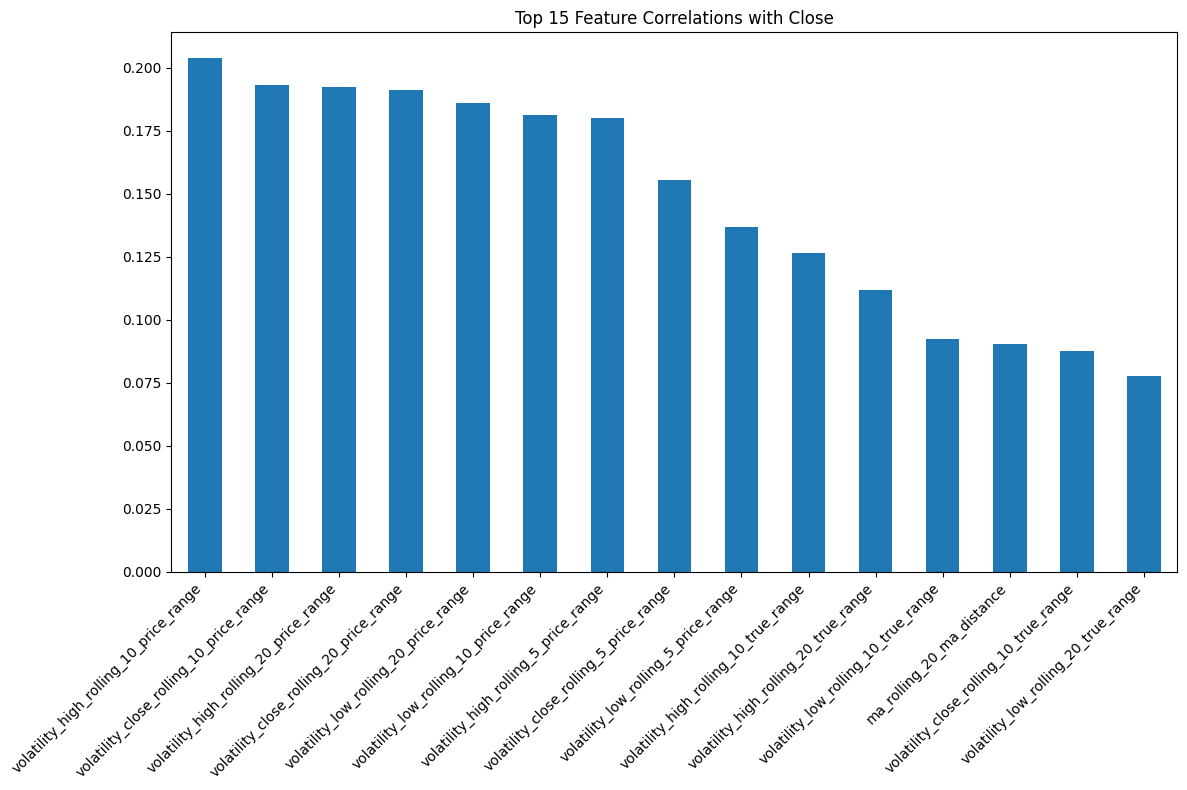


最终数据形状: (961, 580)


In [8]:
class EnhancedFeatureTransformer(FeatureTransformer):
    """增强版特征转换器，支持配置管理"""

    def __init__(self, df: pd.DataFrame, config_manager: Optional[FeatureConfigManager] = None):
        """
        初始化

        参数:
        df: pd.DataFrame - 输入数据框
        config_manager: Optional[FeatureConfigManager] - 特征配置管理器
        """
        super().__init__(df)
        self.config_manager = config_manager or FeatureConfigManager()
        self.generated_features = []  # 记录生成的特征

        # 定义内置函数映射
        self.built_in_functions = {
            'mean': np.mean,
            'std': np.std,
            'min': np.min,
            'max': np.max,
            'median': np.median,
            'sum': np.sum,
            'var': np.var,
            'skew': lambda x: pd.Series(x).skew(),
            'kurt': lambda x: pd.Series(x).kurtosis(),
            'range': lambda x: np.max(x) - np.min(x)
        }

        # 定义自定义函数映射
        self.custom_functions = {
            # 基础技术指标
            'zscore': self._zscore,
            'slope': self._slope,
            'volatility': self._volatility,
            'momentum': self._momentum,
            'rsi': self._rsi,

            # 移动平均相关
            'ma_distance': self._ma_distance,  # 当前价格与移动平均的距离
            'ma_distance_pct': self._ma_distance_pct,  # 当前价格与移动平均的距离百分比
            'ma_cross': self._ma_cross,  # 移动平均交叉信号

            # K线形态相关
            'shadow_ratio': self._shadow_ratio,  # 上下影线比例
            'body_ratio': self._body_ratio,  # 实体与整体长度比例
            'upper_shadow_ratio': self._upper_shadow_ratio,  # 上影线与实体比例
            'lower_shadow_ratio': self._lower_shadow_ratio,  # 下影线与实体比例

            # 波动相关
            'price_range': self._price_range,  # 价格范围
            'price_range_pct': self._price_range_pct,  # 价格范围百分比
            'true_range': self._true_range,  # 真实波幅
            'atr_ratio': self._atr_ratio,  # ATR比率
        }


    def _zscore(self, x: np.ndarray) -> float:
        """计算Z分数"""
        if len(x) == 0 or np.std(x) == 0:
            return 0
        return (x[-1] - np.mean(x)) / np.std(x)


    def _slope(self, x: np.ndarray) -> float:
        """计算斜率"""
        if len(x) < 2:
            return 0
        return np.polyfit(np.arange(len(x)), x, 1)[0]

    def _volatility(self, x: np.ndarray) -> float:
        """计算波动率"""
        if len(x) < 2:
            return 0
        returns = np.diff(x) / x[:-1]
        return np.std(returns) * np.sqrt(252)  # 年化波动率

    def _momentum(self, x: np.ndarray) -> float:
        """计算动量"""
        if len(x) < 2:
            return 0
        return (x[-1] / x[0]) - 1

    def _rsi(self, x: np.ndarray) -> float:
        """计算RSI（相对强弱指标）"""
        if len(x) < 2:
            return 50  # 默认中性值

        # 计算价格变化
        diff = np.diff(x)

        # 分离上涨和下跌
        gain = np.where(diff > 0, diff, 0)
        loss = np.where(diff < 0, -diff, 0)

        # 计算平均上涨和下跌
        avg_gain = np.mean(gain)
        avg_loss = np.mean(loss)

        if avg_loss == 0:
            return 100

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        return rsi

    def _ma_distance(self, x: np.ndarray) -> float:
        """
        计算当前价格与移动平均的距离
        """
        if len(x) == 0:
            return 0
        ma = np.mean(x)
        return x[-1] - ma

    def _ma_distance_pct(self, x: np.ndarray) -> float:
        """
        计算当前价格与移动平均的距离百分比
        """
        if len(x) == 0:
            return 0
        ma = np.mean(x)
        if ma == 0:
            return 0
        return (x[-1] - ma) / ma * 100

    def _ma_cross(self, x: np.ndarray) -> float:
        """
        计算移动平均交叉信号
        1: 金叉（快速MA上穿慢速MA）
        -1: 死叉（快速MA下穿慢速MA）
        0: 无交叉
        """
        if len(x) < 2:
            return 0
        # 使用最后两个点判断交叉
        fast_ma = np.mean(x[-5:])  # 5日MA作为快线
        slow_ma = np.mean(x)  # 整个窗口MA作为慢线

        prev_fast_ma = np.mean(x[-6:-1])  # 前一个快线值
        prev_slow_ma = np.mean(x[:-1])  # 前一个慢线值

        # 判断交叉
        if prev_fast_ma <= prev_slow_ma and fast_ma > slow_ma:
            return 1  # 金叉
        elif prev_fast_ma >= prev_slow_ma and fast_ma < slow_ma:
            return -1  # 死叉
        return 0

    def _shadow_ratio(self, x: np.ndarray) -> float:
        """
        计算上下影线比例
        需要OHLC数据，x应该是一个包含[open, high, low, close]的数组
        """
        try:
            if len(x) < 4:
                return 0

            # 获取最后一根K线的OHLC
            open_price = x[-4]
            high_price = x[-3]
            low_price = x[-2]
            close_price = x[-1]

            body_high = max(open_price, close_price)
            body_low = min(open_price, close_price)

            upper_shadow = high_price - body_high
            lower_shadow = body_low - low_price

            # 避免除以零
            if lower_shadow == 0:
                return upper_shadow * 100 if upper_shadow > 0 else 0

            return upper_shadow / lower_shadow

        except Exception:
            return 0

    def _body_ratio(self, x: np.ndarray) -> float:
        """
        计算K线实体与整体长度的比例
        """
        try:
            if len(x) < 4:
                return 0

            open_price = x[-4]
            high_price = x[-3]
            low_price = x[-2]
            close_price = x[-1]

            body_length = abs(close_price - open_price)
            total_length = high_price - low_price

            if total_length == 0:
                return 0

            return body_length / total_length

        except Exception:
            return 0

    def _upper_shadow_ratio(self, x: np.ndarray) -> float:
        """
        计算上影线与实体的比例
        """
        try:
            if len(x) < 4:
                return 0

            open_price = x[-4]
            high_price = x[-3]
            close_price = x[-1]

            body_high = max(open_price, close_price)
            upper_shadow = high_price - body_high
            body_length = abs(close_price - open_price)

            if body_length == 0:
                return upper_shadow * 100 if upper_shadow > 0 else 0

            return upper_shadow / body_length

        except Exception:
            return 0

    def _lower_shadow_ratio(self, x: np.ndarray) -> float:
        """
        计算下影线与实体的比例
        """
        try:
            if len(x) < 4:
                return 0

            open_price = x[-4]
            low_price = x[-2]
            close_price = x[-1]

            body_low = min(open_price, close_price)
            lower_shadow = body_low - low_price
            body_length = abs(close_price - open_price)

            if body_length == 0:
                return lower_shadow * 100 if lower_shadow > 0 else 0

            return lower_shadow / body_length

        except Exception:
            return 0

    def _price_range(self, x: np.ndarray) -> float:
        """
        计算价格范围（高低价差）
        """
        if len(x) == 0:
            return 0
        return np.max(x) - np.min(x)

    def _price_range_pct(self, x: np.ndarray) -> float:
        """
        计算价格范围百分比
        """
        if len(x) == 0:
            return 0
        price_min = np.min(x)
        if price_min == 0:
            return 0
        return (np.max(x) - price_min) / price_min * 100

    def _true_range(self, x: np.ndarray) -> float:
        """
        计算真实波幅（True Range）
        需要high、low、close数据
        """
        try:
            if len(x) < 6:  # 需要至少两组HLC数据
                return 0

            # 当前周期的high、low、close
            high = x[-3]
            low = x[-2]
            close = x[-1]

            # 上一周期的close
            prev_close = x[-4]

            # 计算三个差价
            hl = high - low
            hc = abs(high - prev_close)
            lc = abs(low - prev_close)

            # 返回最大值
            return max(hl, hc, lc)

        except Exception:
            return 0

    def _atr_ratio(self, x: np.ndarray) -> float:
        """
        计算ATR比率（真实波幅与价格的比值）
        """
        try:
            if len(x) < 6:
                return 0

            # 计算真实波幅
            tr = self._true_range(x)

            # 获取当前收盘价
            close = x[-1]

            if close == 0:
                return 0

            # 返回比率
            return tr / close * 100

        except Exception:
            return 0



    def _ensure_list(self, value: Union[str, List[str]]) -> List[str]:
        """
        确保输入为列表形式

        参数:
        value: Union[str, List[str]] - 输入值

        返回:
        List[str] - 转换后的列表
        """
        if isinstance(value, str):
            return [value]
        return value



    def _format_feature_name(self, base_name: str, feature_type: str, params: Dict) -> str:
        """
        格式化特征名称

        参数:
        base_name: str - 基础名称
        feature_type: str - 特征类型
        params: Dict - 参数字典
        """
        if feature_type == 'lag':
            return f"{base_name}_lag_{params['period']}"
        elif feature_type == 'rolling':
            return f"{base_name}_rolling_{params['window']}_{params['function']}"
        elif feature_type == 'rolling_quantile':
            return f"{base_name}_rolling_{params['window']}_quantile_{int(params['quantile']*100)}"
        return base_name

    def _get_prefix(self, config: FeatureConfig, column: str) -> str:
        """
        获取特征前缀

        参数:
        config: FeatureConfig - 特征配置
        column: str - 列名
        """
        if config.prefix is None:
            return column.lower()
        if isinstance(config.prefix, str):
            return config.prefix
        if isinstance(config.prefix, dict):
            return config.prefix.get(column, column.lower())
        return column.lower()

    def apply_configs(self) -> pd.DataFrame:
        """
        应用所有配置生成特征

        返回:
        pd.DataFrame - 包含所有特征的数据框
        """
        self.generated_features = []  # 重置生成的特征列表

        try:
            for config in self.config_manager.configs:
                columns = self._ensure_list(config.columns)

                for column in columns:
                    prefix = self._get_prefix(config, column)

                    # 检查列是否存在
                    if column not in self.df.columns:
                        print(f"警告: 列 '{column}' 不存在，跳过相关特征生成")
                        continue

                    try:
                        if config.feature_type == FeatureType.LAG:
                            for period in config.lag_periods:
                                feature_name = self._format_feature_name(
                                    prefix, 'lag', {'period': period}
                                )
                                self.df[feature_name] = self.df[column].shift(period)
                                self.generated_features.append(feature_name)

                        elif config.feature_type == FeatureType.ROLLING:
                            for window in config.windows:
                                for func in config.functions:
                                    feature_name = self._format_feature_name(
                                        prefix, 'rolling',
                                        {'window': window, 'function': func}
                                    )
                                    rolling = self.df[column].rolling(window=window)
                                    if func in self.built_in_functions:
                                        self.df[feature_name] = rolling.apply(
                                            self.built_in_functions[func]
                                        )
                                    elif func in self.custom_functions:
                                        self.df[feature_name] = rolling.apply(
                                            self.custom_functions[func]
                                        )
                                    self.generated_features.append(feature_name)

                        elif config.feature_type == FeatureType.ROLLING_QUANTILE:
                            for window in config.windows:
                                for quantile in config.quantiles:
                                    feature_name = self._format_feature_name(
                                        prefix, 'rolling_quantile',
                                        {'window': window, 'quantile': quantile}
                                    )
                                    self.df[feature_name] = self.df[column].rolling(
                                        window=window
                                    ).quantile(quantile)
                                    self.generated_features.append(feature_name)

                    except Exception as e:
                        print(f"生成 '{column}' 的特征时出错: {str(e)}")
                        continue

            # 删除包含无穷值的行
            self.df = self.df.replace([np.inf, -np.inf], np.nan)

            return self.df

        except Exception as e:
            print(f"应用配置时出错: {str(e)}")
            raise

    def get_generated_features(self) -> List[str]:
        """
        获取生成的特征列表

        返回:
        List[str] - 特征名称列表
        """
        return self.generated_features

    def get_feature_info(self) -> pd.DataFrame:
        """
        获取特征信息统计

        返回:
        pd.DataFrame - 特征信息统计表
        """
        if not self.generated_features:
            return pd.DataFrame()

        feature_info = []
        for feature in self.generated_features:
            feature_data = self.df[feature]
            info = {
                'feature_name': feature,
                'non_null_count': feature_data.count(),
                'null_count': feature_data.isnull().sum(),
                'null_pct': feature_data.isnull().mean() * 100,
                'mean': feature_data.mean(),
                'std': feature_data.std(),
                'min': feature_data.min(),
                'max': feature_data.max()
            }
            feature_info.append(info)

        return pd.DataFrame(feature_info)

    def plot_feature_correlations(self,
                                target_col: str = None,
                                top_n: int = 20,
                                figsize: Tuple[int, int] = (12, 8)) -> None:
        """
        绘制特征相关性热力图

        参数:
        target_col: str - 目标列名（如果指定，则显示与目标列的相关性）
        top_n: int - 显示前N个相关性最强的特征
        figsize: Tuple[int, int] - 图形大小
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        if not self.generated_features:
            print("没有生成的特征可供分析")
            return

        if target_col is not None:
            if target_col not in self.df.columns:
                print(f"目标列 '{target_col}' 不存在")
                return

            # 计算与目标列的相关性
            correlations = self.df[self.generated_features].corrwith(self.df[target_col])
            correlations = correlations.sort_values(ascending=False)

            # 选择top_n个特征
            top_features = correlations.head(top_n)

            # 绘制条形图
            plt.figure(figsize=figsize)
            top_features.plot(kind='bar')
            plt.title(f'Top {top_n} Feature Correlations with {target_col}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

        else:
            # 计算特征间的相关性矩阵
            corr_matrix = self.df[self.generated_features].corr()

            # 绘制热力图
            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
            plt.title('Feature Correlations')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

# 使用示例
if __name__ == "__main__":
    # 读取数据
    df = pd.read_csv('stock_1d.csv', index_col='Date', parse_dates=True)
    features_df = pd.read_csv('stock_1d_features.csv', index_col='Date', parse_dates=True)

    # 合并数据
    merged_df = merge_features(df, features_df)
    print("合并后的数据形状:", merged_df.shape)

    # 创建配置
    config_manager = FeatureConfigManager()

    # 添加移动平均相关特征
    config_manager.add_rolling_config(
        columns=['Close'],
        windows=[5, 10, 20],
        functions=['ma_distance', 'ma_distance_pct', 'ma_cross'],
        prefix='ma'
    )

    # 添加K线形态特征
    config_manager.add_rolling_config(
        columns=['Open', 'High', 'Low', 'Close'],  # 需要OHLC数据
        windows=[1],  # 只需要单根K线的数据
        functions=['shadow_ratio', 'body_ratio', 'upper_shadow_ratio', 'lower_shadow_ratio'],
        prefix='candle'
    )

    # 添加波动相关特征
    config_manager.add_rolling_config(
        columns=['High', 'Low', 'Close'],
        windows=[5, 10, 20],
        functions=['price_range', 'price_range_pct', 'true_range', 'atr_ratio'],
        prefix='volatility'
    )

    # 创建特征转换器并应用配置
    transformer = EnhancedFeatureTransformer(merged_df, config_manager)
    final_df = transformer.apply_configs()

    # 打印生成的特征
    print("\n生成的特征:")
    for feature in transformer.get_generated_features():
        print(f"- {feature}")

    # 显示特征信息统计
    print("\n特征信息统计:")
    print(transformer.get_feature_info())

    # 绘制特征相关性
    transformer.plot_feature_correlations(target_col='Close', top_n=15)

    print("\n最终数据形状:", final_df.shape)

In [9]:
!pip install python-dateutil
!pip install borax
!pip install holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 4.2 MB/s eta 0:00:00


In [10]:
from typing import Tuple, List, Dict
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from pandas.tseries.offsets import CustomBusinessDay
from dateutil.relativedelta import MO, TH
from borax.calendars.lunardate import LunarDate
#import holidays
import holidays as holidays_lib

class MarketCalendar:
    """市场交易日历类"""

    @staticmethod
    def get_lunar_holiday(year: int, month: int, day: int, days: int = 1) -> List[datetime]:
        """
        获取农历假期对应的公历日期

        参数:
        year: int - 年份
        month: int - 农历月份
        day: int - 农历日期
        days: int - 假期天数

        返回:
        List[datetime] - 假期日期列表（公历）
        """
        lunar_date = LunarDate(year, month, day)
        solar_date = lunar_date.to_solar_date()
        return [datetime.combine(solar_date + timedelta(days=i), datetime.min.time())
                for i in range(days)]

#    def get_us_holidays(year: int) -> List[datetime]:
#        """
#        获取美股市场假期
#
#        参数:
#        year: int - 年份
#
#        返回:
#        List[datetime] - 假期日期列表
#        """
#        # 使用holidays库获取美国联邦假期
#        us_holiday_dict = holidays.US(years=year)
#
#        # 获取基本假期
#        holiday_dates = set()
#
#        # 添加固定假期和特殊计算的假期
#        for date_obj, name in us_holiday_dict.items():
#            # 将date对象转换为datetime对象
#            if isinstance(date_obj, datetime):
#                holiday_date = date_obj
#            else:
#                holiday_date = datetime.combine(date_obj, datetime.min.time())
#
#            # 排除非交易所假期
#            if name in [
#                "New Year's Day",
#                "Martin Luther King Jr. Day",
#                "Presidents' Day",
#                "Good Friday",  # 需要特殊处理
#                "Memorial Day",
#                "Juneteenth National Independence Day",
#                "Independence Day",
#                "Labor Day",
#                "Thanksgiving",
#                "Christmas Day"
#            ]:
#                holiday_dates.add(holiday_date)  # 使用转换后的holiday_date
#
#        # 特殊处理:
#        # 1. 如果假期在周六，则周五休市
#        # 2. 如果假期在周日，则周一休市
#        final_dates = set()
#        for date_obj in holiday_dates:
#            if date_obj.weekday() == 5:  # 周六
#                final_dates.add(date_obj - timedelta(days=1))
#            elif date_obj.weekday() == 6:  # 周日
#                final_dates.add(date_obj + timedelta(days=1))
#            else:
#                final_dates.add(date_obj)
#
#        # 添加耶稣受难日（Good Friday）
#        def get_easter_sunday(year):
#            a = year % 19
#            b = year // 100
#            c = year % 100
#            d = b // 4
#            e = b % 4
#            f = (b + 8) // 25
#            g = (b - f + 1) // 3
#            h = (19 * a + b - d - g + 15) % 30
#            i = c // 4
#            k = c % 4
#            l = (32 + 2 * e + 2 * i - h - k) % 7
#            m = (a + 11 * h + 22 * l) // 451
#            month = (h + l - 7 * m + 114) // 31
#            day = ((h + l - 7 * m + 114) % 31) + 1
#            return datetime(year, month, day)
#
#        easter_sunday = get_easter_sunday(year)
#        good_friday = easter_sunday - timedelta(days=2)
#        final_dates.add(good_friday)
#
#        return sorted(list(final_dates))

    @staticmethod
    def get_hk_holidays(year: int) -> List[datetime]:
        """
        获取港股市场假期

        参数:
        year: int - 年份

        返回:
        List[datetime] - 假期日期列表
        """
        holidays = []

        # 固定日期的假期
        fixed_holidays = {
            "NEW_YEARS_DAY": [(1, 1, 1)],  # (月,日,天数)
            "LABOR_DAY": [(5, 1, 1)],
            "HONG_KONG_SAR_DAY": [(7, 1, 1)],
            "NATIONAL_DAY": [(10, 1, 1)],
            "CHRISTMAS": [(12, 25, 2)],  # 圣诞节和节礼日
        }

        # 添加固定假期
        for dates in fixed_holidays.values():
            for month, day, days in dates:
                holiday_date = datetime(year, month, day)
                for i in range(days):
                    holidays.append(holiday_date + timedelta(days=i))

        # 农历假期
        lunar_holidays = {
            "CHINESE_NEW_YEAR": [(1, 1, 3)],  # 春节
            "CHING_MING_FESTIVAL": [(3, 5, 1)],  # 清明节
            "DRAGON_BOAT_FESTIVAL": [(5, 5, 1)],  # 端午节
            "MID_AUTUMN_FESTIVAL": [(8, 15, 1)],  # 中秋节
            "CHUNG_YEUNG_FESTIVAL": [(9, 9, 1)],  # 重阳节
        }

        # 添加农历假期
        for dates in lunar_holidays.values():
            for month, day, days in dates:
                holidays.extend(MarketCalendar.get_lunar_holiday(year, month, day, days))

        # 复活节和耶稣受难日
        def get_easter_sunday(year):
            a = year % 19
            b = year // 100
            c = year % 100
            d = b // 4
            e = b % 4
            f = (b + 8) // 25
            g = (b - f + 1) // 3
            h = (19 * a + b - d - g + 15) % 30
            i = c // 4
            k = c % 4
            l = (32 + 2 * e + 2 * i - h - k) % 7
            m = (a + 11 * h + 22 * l) // 451
            month = (h + l - 7 * m + 114) // 31
            day = ((h + l - 7 * m + 114) % 31) + 1
            return datetime(year, month, day)

        easter_sunday = get_easter_sunday(year)
        good_friday = easter_sunday - timedelta(days=2)
        easter_monday = easter_sunday + timedelta(days=1)
        holidays.extend([good_friday, easter_monday])

        return sorted(list(set(holidays)))


    @staticmethod
    def get_us_holidays(year: int) -> List[datetime]:
        """
        获取美股市场假期

        参数:
        year: int - 年份

        返回:
        List[datetime] - 假期日期列表
        """
        try:
            # 创建美国假期日历实例
            us_calendar = holidays_lib.country_holidays('US', years=year)

            # 获取基本假期
            holiday_dates = set()

            # 添加固定假期和特殊计算的假期
            for date_obj, name in us_calendar.items():
                # 将date对象转换为datetime对象
                if isinstance(date_obj, datetime):
                    holiday_date = date_obj
                else:
                    holiday_date = datetime.combine(date_obj, datetime.min.time())

                # 排除非交易所假期
                if name in [
                    "New Year's Day",
                    "Martin Luther King Jr. Day",
                    "Presidents' Day",
                    "Good Friday",  # 需要特殊处理
                    "Memorial Day",
                    "Juneteenth National Independence Day",
                    "Independence Day",
                    "Labor Day",
                    "Thanksgiving",
                    "Christmas Day"
                ]:
                    holiday_dates.add(holiday_date)

            # 特殊处理:
            # 1. 如果假期在周六，则周五休市
            # 2. 如果假期在周日，则周一休市
            final_dates = set()
            for date_obj in holiday_dates:
                if date_obj.weekday() == 5:  # 周六
                    final_dates.add(date_obj - timedelta(days=1))
                elif date_obj.weekday() == 6:  # 周日
                    final_dates.add(date_obj + timedelta(days=1))
                else:
                    final_dates.add(date_obj)

            # 添加耶稣受难日（Good Friday）
            def get_easter_sunday(year):
                a = year % 19
                b = year // 100
                c = year % 100
                d = b // 4
                e = b % 4
                f = (b + 8) // 25
                g = (b - f + 1) // 3
                h = (19 * a + b - d - g + 15) % 30
                i = c // 4
                k = c % 4
                l = (32 + 2 * e + 2 * i - h - k) % 7
                m = (a + 11 * h + 22 * l) // 451
                month = (h + l - 7 * m + 114) // 31
                day = ((h + l - 7 * m + 114) % 31) + 1
                return datetime(year, month, day)

            easter_sunday = get_easter_sunday(year)
            good_friday = easter_sunday - timedelta(days=2)
            final_dates.add(good_friday)

            return sorted(list(final_dates))

        except Exception as e:
            print(f"获取美国假期时出错: {str(e)}")  # 添加错误信息打印
            raise  # 重新抛出异常


    @staticmethod
    def get_cn_holidays(year: int) -> List[datetime]:
        """
        获取A股市场假期

        参数:
        year: int - 年份

        返回:
        List[datetime] - 假期日期列表
        """
        holidays = []

        # 固定日期的假期
        fixed_holidays = {
            "NEW_YEARS_DAY": [(1, 1, 1)],  # (月,日,天数)
            "LABOR_DAY": [(5, 1, 5)],  # 五一假期
            "NATIONAL_DAY": [(10, 1, 7)],  # 国庆节
        }

        # 添加固定假期
        for dates in fixed_holidays.values():
            for month, day, days in dates:
                holiday_date = datetime(year, month, day)
                for i in range(days):
                    holidays.append(holiday_date + timedelta(days=i))

        # 农历假期
        lunar_holidays = {
            "CHINESE_NEW_YEAR": [(1, 1, 7)],  # 春节
            "CHING_MING_FESTIVAL": [(3, 5, 3)],  # 清明节
            "DRAGON_BOAT_FESTIVAL": [(5, 5, 3)],  # 端午节
            "MID_AUTUMN_FESTIVAL": [(8, 15, 3)],  # 中秋节
        }

        # 添加农历假期
        for dates in lunar_holidays.values():
            for month, day, days in dates:
                holidays.extend(MarketCalendar.get_lunar_holiday(year, month, day, days))

        return sorted(list(set(holidays)))

    @staticmethod
    def get_market_holidays(market: str, year: int) -> List[datetime]:
        """
        获取指定市场和年份的假期列表

        参数:
        market: str - 市场类型 ('US', 'HK', 'CN')
        year: int - 年份

        返回:
        List[datetime] - 假期日期列表
        """
        #market_holiday_funcs = {
        #    'US': MarketCalendar.get_us_holidays,
        #    'HK': MarketCalendar.get_hk_holidays,
        #    'CN': MarketCalendar.get_cn_holidays
        #}
        #
        #if market not in market_holiday_funcs:
        #    raise ValueError(f"不支持的市场类型: {market}")
        #
        #return market_holiday_funcs[market](year)

        # 将市场类型转换为大写
        market = market.upper()

        # 使用对应的假期获取函数
        if market == 'US':
            return MarketCalendar.get_us_holidays(year)
        elif market == 'HK':
            return MarketCalendar.get_hk_holidays(year)
        elif market == 'CN':
            return MarketCalendar.get_cn_holidays(year)
        else:
            raise ValueError(f"不支持的市场类型: {market}")

class DataCleaner:
    """股票数据清洗类"""

    def __init__(self, df: pd.DataFrame, market: str = 'CN', price_limit: float = None):
        """
        初始化

        参数:
        df: pd.DataFrame - 包含OHLCV数据的DataFrame
        market: str - 市场类型 ('US', 'HK', 'CN')
        price_limit: float - 涨跌幅限制
        """
        self.df = df.copy()
        self.market = market.upper()
        self.price_limit = price_limit

        # 确保列名标准化
        self.df.columns = [col.lower() for col in self.df.columns]

        # 验证市场类型
        valid_markets = ['US', 'HK', 'CN']
        if self.market not in valid_markets:
            raise ValueError(f"市场类型必须是 {valid_markets} 之一")

        # 设置默认涨跌幅限制
        if price_limit is None:
            if market == 'CN':
                self.price_limit = 0.1  # A股默认10%涨跌幅
            elif market == 'HK':
                self.price_limit = None  # 港股无涨跌幅限制
            else:
                self.price_limit = None  # 美股无涨跌幅限制

# 使用示例
if __name__ == "__main__":
    # 读取数据
    df = pd.read_csv('stock_1d.csv', index_col='Date', parse_dates=True)

    # 测试不同市场的假期计算
    year = 2023
    markets = ['US', 'HK', 'CN']

    for market in markets:
        print(f"\n{market}市场 {year}年假期列表:")
        print("="*50)
        holidays = MarketCalendar.get_market_holidays(market, year)
        for holiday in holidays:
            print(holiday.strftime('%Y-%m-%d'))


US市场 2023年假期列表:
2023-01-02
2023-01-16
2023-04-07
2023-05-29
2023-06-19
2023-07-04
2023-09-04
2023-12-25

HK市场 2023年假期列表:
2023-01-01
2023-01-22
2023-01-23
2023-01-24
2023-04-07
2023-04-10
2023-04-24
2023-05-01
2023-06-22
2023-07-01
2023-09-29
2023-10-01
2023-10-23
2023-12-25
2023-12-26

CN市场 2023年假期列表:
2023-01-01
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-04-24
2023-04-25
2023-04-26
2023-05-01
2023-05-02
2023-05-03
2023-05-04
2023-05-05
2023-06-22
2023-06-23
2023-06-24
2023-09-29
2023-09-30
2023-10-01
2023-10-02
2023-10-03
2023-10-04
2023-10-05
2023-10-06
2023-10-07


In [11]:
class DataCleaner:
    """股票数据清洗类"""

    def __init__(self, df: pd.DataFrame, market: str = 'US', price_limit: float = None):
        """
        初始化

        参数:
        df: pd.DataFrame - 包含OHLCV数据的DataFrame
        market: str - 市场类型 ('US', 'HK', 'CN')，默认为'US'
        price_limit: float - 涨跌幅限制，如0.1表示10%涨跌幅限制，None表示无涨跌幅限制
        """
        self.df = df.copy()
        self.market = market.upper()
        # 确保列名标准化
        self.df.columns = [col.lower() for col in self.df.columns]

        # 验证市场类型
        valid_markets = ['US', 'HK', 'CN']
        if self.market not in valid_markets:
            raise ValueError(f"市场类型必须是 {valid_markets} 之一")

        # 设置默认涨跌幅限制
        if price_limit is None:
            if market == 'CN':
                self.price_limit = 0.1  # A股默认10%涨跌幅
            else:
                self.price_limit = None  # 其他市场默认无涨跌幅限制
        else:
            self.price_limit = price_limit


    def check_date_index(self) -> Tuple[bool, str]:
        """
        检查日期索引
        - 确保索引为日期类型
        - 检查日期是否有重复
        - 确保日期按升序排列
        """
        try:
            # 确保索引为日期类型
            if not isinstance(self.df.index, pd.DatetimeIndex):
                try:
                    self.df.index = pd.to_datetime(self.df.index)
                except Exception as e:
                    return False, f"无法将索引转换为日期类型: {str(e)}"

            # 检查日期重复
            if self.df.index.duplicated().any():
                dup_dates = self.df.index[self.df.index.duplicated()].unique()
                return False, f"存在重复日期: {dup_dates}"

            # 检查日期排序
            if not self.df.index.is_monotonic_increasing:
                return False, "日期未按升序排列"

            return True, "日期索引检查通过"

        except Exception as e:
            return False, f"日期检查过程出错: {str(e)}"



    def check_volume_validity(self) -> Tuple[bool, str]:
        """
        检查成交量数据的有效性
        - 成交量为非负整数
        - 检查异常成交量
        """
        try:
            # 检查负数成交量
            if (self.df['volume'] < 0).any():
                invalid_dates = self.df[self.df['volume'] < 0].index
                return False, f"存在负数成交量 在 {invalid_dates}"

            # 检查成交量是否为整数
            if not self.df['volume'].dtype.kind in 'iu':  # i:整数, u:无符号整数
                return False, "成交量不是整数类型"

            # 检查异常成交量
            volume_mean = self.df['volume'].mean()
            volume_std = self.df['volume'].std()
            abnormal_volume = self.df[abs(self.df['volume'] - volume_mean) > 5 * volume_std]
            if not abnormal_volume.empty:
                return False, f"存在异常成交量: \n{abnormal_volume}"

            return True, "成交量数据检查通过"

        except Exception as e:
            return False, f"成交量检查过程出错: {str(e)}"


    def check_missing_values(self) -> Tuple[bool, str]:
        """
        检查缺失值
        """
        try:
            missing = self.df.isnull().sum()
            if missing.any():
                return False, f"存在缺失值:\n{missing[missing > 0]}"
            return True, "无缺失值"

        except Exception as e:
            return False, f"缺失值检查过程出错: {str(e)}"


    def check_trading_dates(self) -> Tuple[bool, str]:
        """
        检查交易日期的连续性

        返回:
        Tuple[bool, str] - (检查是否通过, 详细信息)
        """
        try:
            # 获取数据的起止年份
            start_year = self.df.index.min().year
            end_year = self.df.index.max().year

            # 收集所有假期
            all_holidays = set()
            try:
                for year in range(start_year, end_year + 1):
                    holidays = MarketCalendar.get_market_holidays(self.market, year)
                    MarketCalendar.get_market_holidays(market, year)
                    all_holidays.update(holidays)
            except Exception as e:
                return False, f"获取假期数据失败: {str(e)}"

            # 获取所有工作日
            all_workdays = pd.date_range(
                start=self.df.index.min(),
                end=self.df.index.max(),
                freq='B'
            )

            # 排除节假日，得到应该交易的日期
            trading_days = set(all_workdays) - all_holidays

            # 检查缺失的交易日
            missing_dates = trading_days - set(self.df.index)

            # 检查多余的交易日（在节假日进行的交易）
            extra_dates = set(self.df.index) - trading_days

            messages = []
            if missing_dates:
                messages.append(f"缺失以下交易日:\n{sorted(missing_dates)}")

            if extra_dates:
                messages.append(f"以下日期为非交易日，但有交易数据:\n{sorted(extra_dates)}")

            if messages:
                return False, "\n".join(messages)

            return True, "交易日期检查通过"

        except Exception as e:
            return False, f"交易日期检查过程出错: {str(e)}"

    def check_price_limit(self) -> Tuple[bool, str]:
        """
        检查涨跌幅限制

        返回:
        Tuple[bool, str] - (检查是否通过, 详细信息)
        """
        if self.price_limit is None:
            return True, "无涨跌幅限制"

        try:
            # 计算理论涨停价和跌停价
            prev_close = self.df['close'].shift(1)
            up_limit = prev_close * (1 + self.price_limit)
            down_limit = prev_close * (1 - self.price_limit)

            # 检查是否超过涨跌幅限制
            violations = []

            # 检查最高价是否超过涨停
            high_violations = self.df[self.df['high'] > up_limit]
            if not high_violations.empty:
                violations.append(f"以下日期最高价超过涨停价:\n{high_violations[['high']].join(up_limit.rename('涨停价'))}")

            # 检查最低价是否超过跌停
            low_violations = self.df[self.df['low'] < down_limit]
            if not low_violations.empty:
                violations.append(f"以下日期最低价超过跌停价:\n{low_violations[['low']].join(down_limit.rename('跌停价'))}")

            # 检查OHLC是否都在涨跌停范围内
            for col in ['open', 'high', 'low', 'close']:
                over_limit = self.df[
                    (self.df[col] > up_limit) |
                    (self.df[col] < down_limit)
                ]
                if not over_limit.empty:
                    violations.append(f"以下日期{col}价格超出涨跌停范围:\n{over_limit[[col]]}")

            if violations:
                return False, "\n".join(violations)

            return True, f"所有价格都在{self.price_limit*100}%涨跌幅限制范围内"

        except Exception as e:
            return False, f"涨跌幅检查过程出错: {str(e)}"

    def check_price_validity(self) -> Tuple[bool, str]:
        """
        检查价格数据的有效性
        - 价格为非负数
        - 高低价关系合理
        """
        try:
            # 检查是否有负数或0价格
            for col in ['open', 'high', 'low', 'close']:
                if (self.df[col] <= 0).any():
                    invalid_dates = self.df[self.df[col] <= 0].index
                    return False, f"{col}列在{invalid_dates}存在非正数值"

            # 检查高低价关系
            price_errors = []
            if (self.df['high'] < self.df['low']).any():
                dates = self.df[self.df['high'] < self.df['low']].index
                price_errors.append(f"最高价小于最低价 在 {dates}")

            if (self.df['high'] < self.df['open']).any():
                dates = self.df[self.df['high'] < self.df['open']].index
                price_errors.append(f"最高价小于开盘价 在 {dates}")

            if (self.df['high'] < self.df['close']).any():
                dates = self.df[self.df['high'] < self.df['close']].index
                price_errors.append(f"最高价小于收盘价 在 {dates}")

            if (self.df['low'] > self.df['open']).any():
                dates = self.df[self.df['low'] > self.df['open']].index
                price_errors.append(f"最低价大于开盘价 在 {dates}")

            if (self.df['low'] > self.df['close']).any():
                dates = self.df[self.df['low'] > self.df['close']].index
                price_errors.append(f"最低价大于收盘价 在 {dates}")

            if price_errors:
                return False, "\n".join(price_errors)

            return True, "价格数据检查通过"

        except Exception as e:
            return False, f"价格检查过程出错: {str(e)}"

    def clean_data(self) -> pd.DataFrame:
        """
        清洗数据
        - 排序
        - 删除重复日期
        - 删除异常数据
        - 删除超出涨跌幅限制的数据
        """
        # 排序
        self.df = self.df.sort_index()

        # 删除重复日期
        self.df = self.df[~self.df.index.duplicated(keep='first')]

        # 删除非正常价格的数据
        self.df = self.df[
            (self.df['open'] > 0) &
            (self.df['high'] > 0) &
            (self.df['low'] > 0) &
            (self.df['close'] > 0) &
            (self.df['high'] >= self.df['low']) &
            (self.df['high'] >= self.df['open']) &
            (self.df['high'] >= self.df['close']) &
            (self.df['low'] <= self.df['open']) &
            (self.df['low'] <= self.df['close'])
        ]

        # 删除超出涨跌幅限制的数据
        if self.price_limit is not None:
            prev_close = self.df['close'].shift(1)
            up_limit = prev_close * (1 + self.price_limit)
            down_limit = prev_close * (1 - self.price_limit)

            self.df = self.df[
                (self.df['open'].between(down_limit, up_limit)) &
                (self.df['high'].between(down_limit, up_limit)) &
                (self.df['low'].between(down_limit, up_limit)) &
                (self.df['close'].between(down_limit, up_limit))
            ]

        # 删除非正常成交量的数据
        volume_mean = self.df['volume'].mean()
        volume_std = self.df['volume'].std()
        self.df = self.df[abs(self.df['volume'] - volume_mean) <= 5 * volume_std]

        return self.df

    def run_all_checks(self) -> None:
        """
        运行所有检查
        """
        checks = [
            ('日期索引检查', self.check_date_index()),
            ('价格数据检查', self.check_price_validity()),
            ('涨跌幅检查', self.check_price_limit()),
            ('成交量数据检查', self.check_volume_validity()),
            ('缺失值检查', self.check_missing_values()),
            ('交易日期检查', self.check_trading_dates())
        ]

        print("数据检查报告:")
        print("=" * 50)
        for check_name, (status, message) in checks:
            print(f"\n{check_name}:")
            print("状态:", "通过" if status else "失败")
            print("详情:", message)
        print("\n" + "=" * 50)

# 使用示例
if __name__ == "__main__":
    # 读取数据
    df = pd.read_csv('stock_1d.csv', index_col='Date', parse_dates=True)

    # 创建不同涨跌幅限制的清洗器实例

    # 无涨跌幅限制
    cleaner_no_limit = DataCleaner(df, market='US', price_limit=None)
    print("\n无涨跌幅限制的检查结果:")
    cleaner_no_limit.run_all_checks()

#    # 10%涨跌幅限制
#    cleaner_10pct = DataCleaner(df, price_limit=0.1)
#    print("\n10%涨跌幅限制的检查结果:")
#    cleaner_10pct.run_all_checks()
#
#    # 20%涨跌幅限制
#    cleaner_20pct = DataCleaner(df, price_limit=0.2)
#    print("\n20%涨跌幅限制的检查结果:")
#    cleaner_20pct.run_all_checks()
#
#    # 30%涨跌幅限制
#    cleaner_30pct = DataCleaner(df, price_limit=0.3)
#    print("\n30%涨跌幅限制的检查结果:")
#    cleaner_30pct.run_all_checks()


无涨跌幅限制的检查结果:
数据检查报告:

日期索引检查:
状态: 通过
详情: 日期索引检查通过

价格数据检查:
状态: 通过
详情: 价格数据检查通过

涨跌幅检查:
状态: 通过
详情: 无涨跌幅限制

成交量数据检查:
状态: 失败
详情: 存在异常成交量: 
                 close        high        low        open     volume
Date                                                                
2020-02-28   66.338753   67.564287  62.215637   62.431625  426510000
2020-03-12   60.240219   65.523343  60.184404   62.111276  418474000
2020-03-20   55.631744   61.113863  55.330821   59.985403  401693200
2020-07-31  103.427513  103.578380  98.137385  100.142478  374336800

缺失值检查:
状态: 通过
详情: 无缺失值

交易日期检查:
状态: 失败
详情: 缺失以下交易日:
[Timestamp('2020-02-17 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-11-25 00:00:00'), Timestamp('2022-02-21 00:00:00'), Timestamp('2022-11-24 00:00:00'), Timestamp('2023-02-20 00:00:00')]
以下日期为非交易日，但有交易数据:
[Timestamp('2021-06-18 00:00:00'), Timestamp('2021-12-31 00:00:00')]

